In [263]:
import os
import keras
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import scipy.io as sio
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras import Model
from keras.layers import Layer
from keras.callbacks import Callback
from keras import layers, regularizers, optimizers, losses, metrics, callbacks

NUM_REALIZATIONS = 100
X_CHANNELS = 4
Y_CHANNELS = 2
NX  = 160
NY  = 160
NTT = 60
NT1 = 30
NT0 = 24

EPOCHS = 101
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
MONITOR = 10

In [264]:
X_data = np.zeros((NUM_REALIZATIONS, X_CHANNELS, NX, NY))
c_data = np.zeros((NUM_REALIZATIONS, 5, 30))
y1_data = np.zeros((NUM_REALIZATIONS, Y_CHANNELS, NX, NY, NT1))
y2_data = np.zeros((NUM_REALIZATIONS, Y_CHANNELS, NX, NY, NT1))

for i in tqdm(range(NUM_REALIZATIONS), desc='Loading data'):
    X_data[i] = np.load('data/features/features_{}.npy'.format(i))[:-1,...,0]

    c = sio.loadmat('controls/controls_{}.mat'.format(i), simplify_cells=True)['var']
    if len(c.shape) == 1:
        c = c.reshape(1, -1)
    c_data[i,:c.shape[0]] = c

    y = np.load('data/targets/targets_{}.npy'.format(i))
    y1_data[i] = y[...,:NT1]
    y2_data[i] = y[...,NT1:]

X_data = np.moveaxis(X_data, 1, -1)
c_data = np.moveaxis(c_data, 1, -1)
y1_data = np.moveaxis(np.moveaxis(y1_data, -1, 2), 1, -1)
y2_data = np.moveaxis(np.moveaxis(y2_data, -1, 2), 1, -1)

print('X: {} | c: {}'.format(X_data.shape, c_data.shape))
print('y1: {} | y2: {}'.format(y1_data.shape, y2_data.shape))

Loading data: 100%|██████████| 100/100 [00:18<00:00,  5.42it/s]

X: (100, 160, 160, 4) | c: (100, 30, 5)
y1: (100, 30, 160, 160, 2) | y2: (100, 30, 160, 160, 2)


In [275]:
train_idx = np.random.choice(range(len(X_data)), 80, replace=False)
test_idx  = np.setdiff1d(range(len(X_data)), train_idx)

X_train = X_data[train_idx]
c_train = c_data[train_idx, :NT0]
y1_train = y1_data[train_idx, :NT0]
y2_train = y2_data[train_idx, :NT0]

X_test = X_data[test_idx]
c_test = c_data[test_idx, :NT0]
y1_test = y1_data[test_idx, :NT0]
y2_test = y2_data[test_idx, :NT0]

print('X_train:  {}     | c_train: {}'.format(X_train.shape, c_train.shape))
print('y1_train: {} | y2_train: {}'.format(y1_train.shape, y2_train.shape))
print('-'*70)
print('X_test:  {}     | c_test: {}'.format(X_test.shape, c_test.shape))
print('y1_test: {} | y2_test: {}'.format(y1_test.shape, y2_test.shape))

X_train:  (80, 160, 160, 4)     | c_train: (80, 24, 5)
y1_train: (80, 24, 160, 160, 2) | y2_train: (80, 24, 160, 160, 2)
----------------------------------------------------------------------
X_test:  (20, 160, 160, 4)     | c_test: (20, 24, 5)
y1_test: (20, 24, 160, 160, 2) | y2_test: (20, 24, 160, 160, 2)


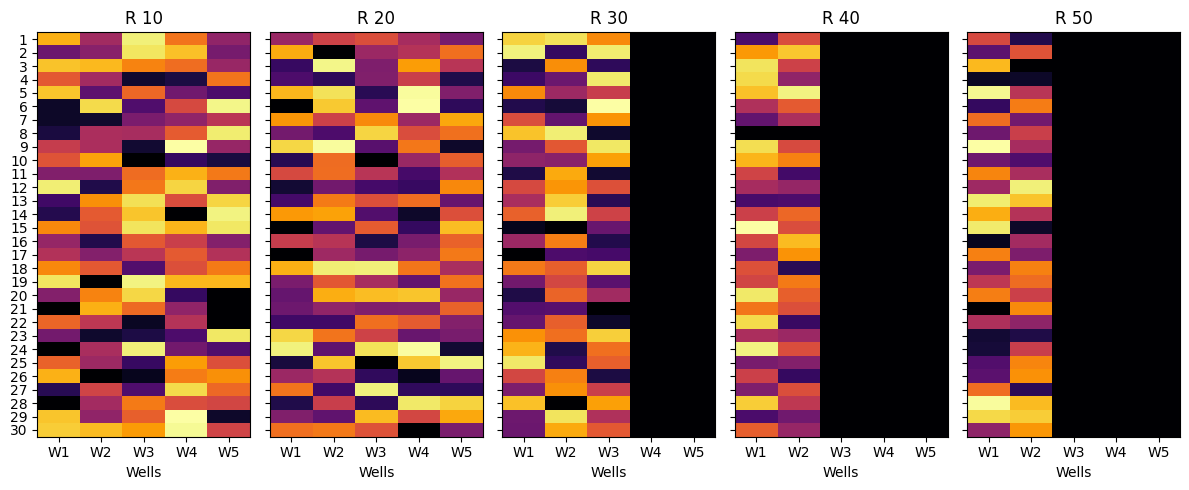

In [267]:
fig, axs = plt.subplots(1, 5, figsize=(12,5), sharex=True, sharey=True)
for j in range(5):
    ax = axs[j]
    i = j*10+10
    ax.imshow(c_data[i], aspect='auto', cmap='inferno')
    ax.set(yticks=np.arange(30), yticklabels=np.arange(1,31), xticks=range(5), xticklabels=['W{}'.format(i) for i in range(1,6)])
    ax.set(xlabel='Wells', ylabel='Injectors' if i==0 else None, title='R {}'.format(i))
plt.tight_layout()
plt.show()

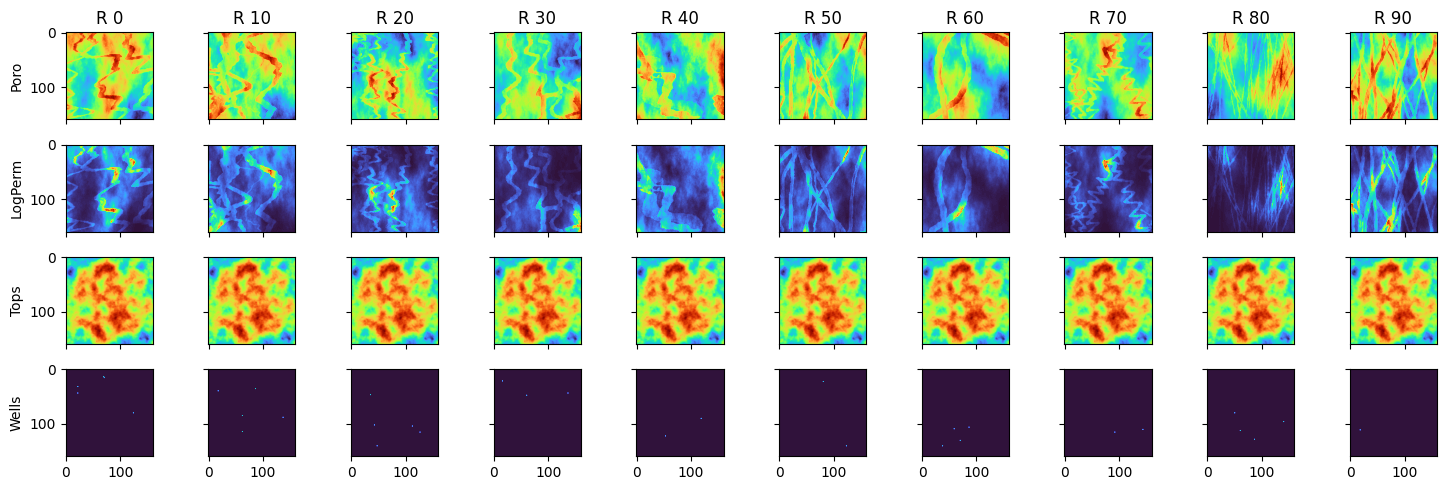

In [272]:
labels = ['Poro','LogPerm','Tops','Wells']
fig, axs = plt.subplots(4, 10, figsize=(15,5), sharex=True, sharey=True)
for i in range(4):
    for j in range(10):
        ax = axs[i,j]
        k = j*10
        ax.imshow(X_data[k,...,i], cmap='turbo')
        ax.set(title='R {}'.format(k) if i==0 else None)
        ax.set(ylabel=labels[i]) if j==0 else None
plt.tight_layout()
plt.show()

In [276]:
class SqueezeExcite(Layer):
    def __init__(self, ratio=4, **kwargs):
        super(SqueezeExcite, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D()
        self.excite1 = layers.Dense(channels // self.ratio, activation='relu')
        self.excite2 = layers.Dense(channels, activation='sigmoid')
        super(SqueezeExcite, self).build(input_shape)
    
    def call(self, inputs):
        x = self.squeeze(inputs)
        x = self.excite1(x)
        x = self.excite2(x)
        x = layers.Reshape((1, 1, x.shape[-1]))(x)
        s = layers.Multiply()([inputs, x])
        return layers.Add()([inputs, s])
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [277]:
def encoder_layer(inp, filt, k=3, pad='same', drop=0.1, pool=(2,2)):
    _ = layers.Conv2D(filt, k, activity_regularizer=regularizers.l1(1e-6), padding=pad)(inp)
    _ = SqueezeExcite()(_)
    _ = layers.GroupNormalization(groups=-1)(_)
    _ = layers.PReLU()(_)
    _ = layers.MaxPooling2D(pool)(_)
    _ = layers.SpatialDropout2D(drop)(_)
    return _

In [349]:
def lifting_layer(inp, dim):
    _ = layers.Dense(dim)(inp)
    _ = layers.Activation('gelu')(_)
    _ = layers.Dropout(0.1)(_)
    return _

In [367]:
def recurrent_step(inp, filt, res, kern=3, pad='same', drop=0.0, leaky_slope=0.3):
    y = layers.ConvLSTM2D(filt, kern, padding=pad)(inp)
    y = layers.GroupNormalization(groups=-1)(y)
    y = layers.LeakyReLU(leaky_slope)(y)
    y = layers.Conv2DTranspose(filt, kern, padding=pad, strides=2)(y)
    y = layers.SpatialDropout2D(drop)(y)
    y = layers.Concatenate()([y, res])
    y = layers.Conv2D(filt, kern, padding=pad)(y)
    y = layers.Activation('sigmoid')(y)
    y = keras.ops.expand_dims(y,1)
    return y

def recurrent_last(inp, filt, kern=3, pad='same', drop=0.0, leaky_slope=0.3, out_channels=2):
    y = layers.ConvLSTM2D(filt, kern, padding=pad)(inp)
    y = layers.GroupNormalization(groups=-1)(y)
    y = layers.LeakyReLU(leaky_slope)(y)
    y = layers.Conv2DTranspose(filt, kern, padding=pad, strides=2)(y)
    y = layers.SpatialDropout2D(drop)(y)
    y = layers.Conv2D(out_channels, kern, padding=pad)(y)
    y = layers.Activation('sigmoid')(y)
    y = keras.ops.expand_dims(y, 1)
    return y

def conditional_recurrent_decoder(z_input, c_input, residuals, rnn_filters=[16,64,256], 
                                  previous_timestep=None, dropout=0.1, leaky_slope=0.3, out_channels:int=2):
    zz = keras.ops.expand_dims(z_input, 1)
    cc = keras.ops.expand_dims(c_input, 1)
    _ = keras.ops.einsum('bthwc,btc->bthwc', zz, cc)
    _ = recurrent_step(_, rnn_filters[0], residuals[0], drop=dropout, leaky_slope=leaky_slope)
    _ = recurrent_step(_, rnn_filters[1], residuals[1], drop=dropout, leaky_slope=leaky_slope)
    _ = recurrent_last(_, rnn_filters[2], drop=dropout, leaky_slope=leaky_slope, out_channels=out_channels)
    if previous_timestep is not None:
        _ = layers.Concatenate(axis=1)([previous_timestep, _])
    return _

def unconditional_recurrent_decoder(z_input, residuals, rnn_filters=[16,64,256], 
                                    previous_timestep=None, dropout=0.1, leaky_slope=0.3, out_channels:int=2):    
    _ = keras.ops.expand_dims(z_input, 1)
    _ = recurrent_step(_, rnn_filters[0], residuals[0], drop=dropout, leaky_slope=leaky_slope)
    _ = recurrent_step(_, rnn_filters[1], residuals[1], drop=dropout, leaky_slope=leaky_slope)
    _ = recurrent_last(_, rnn_filters[2], drop=dropout, leaky_slope=leaky_slope, out_channels=out_channels)
    if previous_timestep is not None:
        _ = layers.Concatenate(axis=1)([previous_timestep, _])
    return _

In [372]:
def make_model(timesteps=24, verbose:bool=True):
    x_inp = layers.Input(shape=(NX, NY, X_CHANNELS))
    c_inp = layers.Input(shape=(timesteps, 5))

    # Model 1
    x1 = encoder_layer(x_inp, 16)
    x2 = encoder_layer(x1, 64)
    x3 = encoder_layer(x2, 256)
    cc = lifting_layer(c_inp, 256)
    t1 = None
    for t in range(timesteps):
        if t==0:
            t1 = conditional_recurrent_decoder(x3, cc[:,t], [x2, x1])
        else:
            t1 = conditional_recurrent_decoder(x3, cc[:,t], [x2, x1], previous_timestep=t1) 

    # Model 2
    y_inp = layers.Concatenate(axis=-1)([x_inp, t1[:,-1]])
    y1 = encoder_layer(y_inp, 16)
    y2 = encoder_layer(y1, 64)
    y3 = encoder_layer(y2, 256)
    t2 = None
    for t in range(timesteps):
        if t==0:
            t2 = unconditional_recurrent_decoder(y3, [y2, y1])
        else:
            t2 = unconditional_recurrent_decoder(y3, [y2, y1], previous_timestep=t2) 

    model = Model(inputs=[x_inp, c_inp], outputs=[t1, t2])

    if verbose:
        print('# parameters: {:,}'.format(model.count_params()))
    
    return model

In [ ]:
def custom_loss(true, pred, alpha=0.8, beta=0.8, gamma=0.8):

    # perceptual loss
    ssim_loss = tf.reduce_mean(1.0 - tf.image.ssim(true, pred, max_val=1.0))
    psnr_loss = tf.reduce_mean(1.0 / tf.image.psnr(true, pred, max_val=1.0))
    perceptual = gamma * ssim_loss + (1 - gamma) * psnr_loss
    
    # reconstruction loss
    mse_loss = tf.reduce_mean(tf.square(true - pred))
    mae_loss = tf.reduce_mean(tf.abs(true - pred))
    reconstruction = beta * mse_loss + (1 - beta) * mae_loss
    
    # total loss
    return alpha * reconstruction + (1 - alpha) * perceptual

In [373]:
class MonitorCallback(Callback):
    def __init__(self, monitor:int=10):
        super(MonitorCallback, self).__init__()
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.monitor == 0:
            print('Epoch: {} | Loss: {:.5f} | Val Loss: {:.5f}'.format(epoch+1, logs['loss'], logs['val_loss']))

In [375]:
model = make_model()
optimizer = keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model.compile(optimizer=optimizer, loss=custom_loss, metrics=['mse','mse'])

esCallback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
mcCallback = keras.callbacks.ModelCheckpoint('pix2vid-opt.keras', monitor='val_accuracy', save_best_only=True)
customCBs  = [MonitorCallback(monitor=MONITOR), esCallback, mcCallback]

start = time()
fit = model.fit(x=[X_train, c_train], y=[y1_train, y2_train],
                batch_size       = BATCH_SIZE,
                epochs           = EPOCHS,
                validation_split = 0.2,
                shuffle          = True,
                callbacks        = customCBs,
                verbose          = 0)
print('-'*30+'\n'+'Training time: {:.2f} minutes'.format((time()-start)/60))
model.save('pix2vid-opt.keras')
pd.DataFrame(fit.history).to_csv('pix2vid-opt.csv', index=False)

# parameters: 193,995,744
